Name: Kavya Chigurupati

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from IPython import display
import pandas as pd
import tensorflow as tf

In [4]:
path = "/content/drive/MyDrive/ITCS-6156-ML/horses/"

In [5]:

## helper funciton for loading the horses data
#make sure the horses data is in the same directory as the notebook
#do not change this function
def load_horses_orig(path, image_size):   
    mask_path = path + 'masks/'
    image_path = path + 'images/'
    images = []
    masks = []
    test_images= []
    test_masks =[]
    for i in range(328):
        
        orig_im = cv2.imread(image_path + 'image-{}.png'.format(i))
        orig_im= cv2.cvtColor(orig_im, cv2.COLOR_RGB2BGR)
        
        low_im = cv2.resize(orig_im, dsize=(image_size, image_size))

        orig_mask = cv2.imread(mask_path + 'mask-{}.png'.format(i))
        low_mask = cv2.resize(orig_mask, dsize=(image_size, image_size))
        low_mask = cv2.cvtColor(low_mask, cv2.COLOR_RGB2GRAY)
        bin_mask = (low_mask > 0) + 0
        
    
        images.append(low_im)
        masks.append(bin_mask)


    xtest = np.reshape(np.array(images[250:]), (-1,image_size*image_size*3))
    ytest = np.reshape(np.array(masks[250:]), (-1, image_size * image_size))
    xdata = np.reshape(np.array(images[:200]), (-1,image_size*image_size*3))
    ydata = np.reshape(np.array(masks[:200]), (-1, image_size * image_size))
    yval =  np.reshape(np.array(masks[200:250]), (-1, image_size * image_size))
    xval = np.reshape(np.array(images[200:250]), (-1,image_size*image_size*3))


    return xdata, xval, xtest, ydata, yval, ytest


In [6]:
#change the path address if put the data somewhere else
# path = './horses/'
path = "/content/drive/MyDrive/ITCS-6156-ML/horses/"
image_size = 32;
xdata, xval, xtest, ydata, yval, ytest = load_horses_orig(path, image_size)

In [7]:
#helper function to drawing horse and its mask
def draw(image, mask):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(np.reshape(image, (image_size,image_size,3)))
    ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
    plt.show()

The task is to predict the mask for the horse given the image
Mask is binary image shows the presence of the horse.

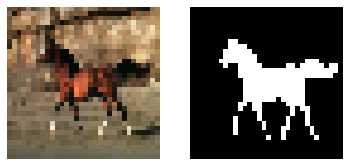

In [8]:
 draw(xdata[0], ydata[0])

In [13]:
train_size = xdata.shape[0]
batch_size = 10
train_dataset = (tf.data.Dataset.from_tensor_slices(np.hstack((xdata, ydata)))
                 .shuffle(train_size).batch(batch_size))

The intersection over union (IOU) is a metric for measuring the performance of image segmentation. The perfect segmentation receives IOU of one.

In [14]:
# Do not change this cell
def iou(ytrue, yprediction):
    yp = yprediction
    yt = ytrue
    yp = yp > 0.5 + 0
    intersect = np.sum(np.minimum(yp, yt),1)
    union = np.sum(np.maximum(yp, yt),1)
    return np.average(intersect / (union+0.0))
        

In [15]:
assert iou(ydata, ydata) == 1.0

We can use feedforwad MLP or CNN  model for image segmentation. Here the input is the image and the output is the segmentation mask.

In [100]:
class NeuralNet(tf.keras.Model):
    
    
    def construct_CNN(self):
        # COMPLETE ME
        pass
        
        self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Conv2D(128,(3,3),dtype='float32',padding = "same"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation(activation='elu'),
                tf.keras.layers.GaussianNoise(0.1),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Dropout(0.1),
             

                tf.keras.layers.Conv2D(256,(3,3),dtype='float32',padding = "same"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation(activation='elu'),
                tf.keras.layers.GaussianNoise(0.1),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Dropout(0.2),
             
                tf.keras.layers.Conv2D(512,(3,3),dtype='float32',padding = "same"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation(activation='elu'),
                tf.keras.layers.GaussianNoise(0.2),
                tf.keras.layers.Dropout(0.2),
             
                tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2,2),padding='same'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation(activation='elu'),
                tf.keras.layers.GaussianNoise(0.1),
                tf.keras.layers.Dropout(0.2),
             
                tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'),  
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Activation(activation='elu'),
                tf.keras.layers.GaussianNoise(0.1),
                tf.keras.layers.Dropout(0.2),
                
                tf.keras.layers.Conv2DTranspose(64,(1, 1), activation = 'elu',padding='same'),
                tf.keras.layers.Conv2DTranspose(32,(1, 1), activation = 'elu',padding='same'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Conv2DTranspose(1, 1,activation='tanh'),
                # tf.keras.layers.Conv2DTranspose(1, 1),
                tf.keras.layers.Flatten(),
                
            ]
        )


        self.model.summary()

    
    def construct_MLP(self):
         self.model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(image_size, image_size, 3), dtype='float32'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(500, activation='relu'),
                tf.keras.layers.Dropout(.2, input_shape=(500,)),
                tf.keras.layers.Dense(20, activation='relu'),
                tf.keras.layers.Dense(image_size*image_size)
            ]
        )
    
    
    def __init__(self, network_type = 'MLP'):
        super(NeuralNet, self).__init__()
        #DOCUMENT ME
        # case 1 - SGD
        # SGD - Gradient Descent minimizes the cost function. When we have a non-convex cost function, the gradient descent 
        # might get stuck at a local minimum instead of finding a global minimum. So, we use stochastic gradient descent(SGD).
        # Def - Instead of using all the data, we can use one data point at a time to skip the local minimum. We might find a solution even
        # our function is not convex - SGD
        # Syntax of function 
        # here we are using learning rate - 0.1,
        # Using an SGD optimizer in this program , I didnot find much change in the loss function and accuracy. So, I used Adam and Adagrad.

        # self.optimizer = tf.keras.optimizers.SGD(0.1)

        #What are the other available optimizers
        #Test your code with different optimizers

        # case 2 - Adagrad
        # Reference for optimizers - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7407771/ 
        # 2. Adagrad - In case of SGD, the learning rates are constant. But for Adagrad the learning rate changes based on the occurance of 
        # parameters. The learning adaptively decreases and might stop learning at some point.It might reach 0. So, we use AdaDelta or Adam.

        # self.optimizer = tf.keras.optimizers.Adagrad(learning_rate=1e-4)

        # case 3 - Adam
        # Adam - Adam is an adaptive optimizer which combines the concepts of SGD and RMSprop. It doesnot work on the current gradient , instead 
        # uses current and previous gradient values. If we are going in the correct direction(where the variance is small), it takes a 
        # larger step as RMSprop
        # I have tested Adam optimizer with different learning rates and 1e-4 worked best for this model.

        # self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) 
        # self.optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4) 
        # self.optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)    
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)   
        
         
        if network_type == 'MLP':
            self.construct_MLP();
        else:
            self.construct_CNN();
        

    #   DOCUMENT ME
    #   Function 1 - forward function :
    #   returns the predicted values for the input x. It passes through all the layers of CNN once.
    #   if predict argument is true then sigmoid activation is applied to model.
    #   else it just returns the model weights
    def forward(self, x, predict=True):
        if predict:
            return tf.nn.sigmoid(self.model(x))
        return self.model(x)


    #Function 2 - get_loss
    #loss function computes how far is our predicted value from the actual value.
    # reshape(-1, dims) = -1 value helps to flatten the image into single dimension(1D)
    # So -> x dimensions would be (1,3072) and y -> dimensions would be (1,1024)
    # ylogits => computes the prediction masks for input data x.(forward pass)
    # since the predict = False , we donot apply sigmoid activation to our output.

    def get_loss(self, x, yt):
        x = tf.reshape(x, (-1, image_size, image_size, 3))
        yt = tf.reshape(yt, (-1, image_size * image_size))
        ylogits = self.forward(x, predict=False);
        
        #DOCUMENT ME
        #What is the difference of sigmoid_cross_entropy_with_logits and sigmoid_cross_entropy?
        # sigmoid_cross_entropy_with_logits helps to solve n binary classification at once. Similar to our case where the output is segementation
        # mask of size 32x32. sigmoid_cross_entropy works for binary classification problems(the output would be in 0 and 1).
        # logits => predicted segmentation masks and labels => are the actual segmentation masks.
       
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=ylogits, labels=yt);
        
        
        return tf.reduce_sum(cross_ent)
  
   
    def train_step(self, xbatch,ybatch):
        
        #computing gradients and updating weights
        #DOCUMENT ME
        # Gradient tape helps to record the valuess. This is helpful while doing backpropogation.
        #computing the loss function where xbatch is the input image and ybatch is the segmentation mask.
        
        with tf.GradientTape() as tape:
            loss = self.get_loss(xbatch, ybatch)

        #DOCUMENT ME
        # computing the gradient with respect to loss. 
        gradients = tape.gradient(loss, model.trainable_variables)
        
        #DOCUMENT ME
        #computing gradients by calling tape.gradient and updating the parameters(such as weights).
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        #computes the summation of the loss values
        return tf.reduce_sum(loss)

    def predict(self, x):
        y = self.forward(x, predict=True)
        return y.numpy() #tf.reshape(y, (-1, image_size, image_size)).numpy()


**Model 1**

1. Testing with Optimizer - Adam
2. Epochs - 2000
3. Activation function for last layer of model - tanh

**Results**

Test Accuracy - 72%

In [19]:
model = NeuralNet('CNN')
# model = NeuralNet('MLP')
train_iou = []
val_iou = []
test_iou = []
epoch = 1;
best_val_iou = -1
best_test_iou = -1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 32, 32, 128)      0         
 se)                                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                        

In [20]:
#Adopt similar training loop for other problems
# can do dataaugumentationa and adding noise if required -- kc

max_epoch = 2000

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou.append(iou(ydata,ydata_pred))
    val_iou.append(iou(yval,yval_pred))
    test_iou.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou[-1]
        best_val_iou = val_iou[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou[-1], val_iou[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 1.21e+05, IOU - Train: 0.0303 Valid: 0.0252 Test: 0.0303
Epoch 2, Loss: 1.15e+05, IOU - Train: 0.08 Valid: 0.0702 Test: 0.0778
Epoch 3, Loss: 1.15e+05, IOU - Train: 0.0561 Valid: 0.0466 Test: 0.0778
Epoch 4, Loss: 1.14e+05, IOU - Train: 0.088 Valid: 0.0803 Test: 0.0848
Epoch 5, Loss: 1.14e+05, IOU - Train: 0.1 Valid: 0.0965 Test: 0.098
Epoch 6, Loss: 1.14e+05, IOU - Train: 0.0777 Valid: 0.0689 Test: 0.098
Epoch 7, Loss: 1.13e+05, IOU - Train: 0.125 Valid: 0.11 Test: 0.118
Epoch 8, Loss: 1.12e+05, IOU - Train: 0.102 Valid: 0.0823 Test: 0.118
Epoch 9, Loss: 1.12e+05, IOU - Train: 0.132 Valid: 0.115 Test: 0.123
Epoch 10, Loss: 1.11e+05, IOU - Train: 0.148 Valid: 0.133 Test: 0.142
Epoch 11, Loss: 1.11e+05, IOU - Train: 0.154 Valid: 0.141 Test: 0.148
Epoch 12, Loss: 1.11e+05, IOU - Train: 0.142 Valid: 0.122 Test: 0.148
Epoch 13, Loss: 1.1e+05, IOU - Train: 0.186 Valid: 0.16 Test: 0.17
Epoch 14, Loss: 1.08e+05, IOU - Train: 0.23 Valid: 0.198 Test: 0.212
Epoch 15, Loss: 1.05e+0

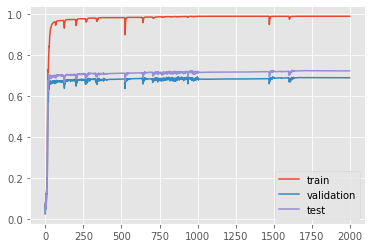

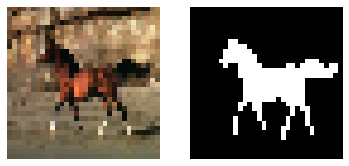

In [21]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou).plot(ax=ax,label="train")
pd.Series(val_iou).plot(ax=ax,label="validation")
pd.Series(test_iou).plot(ax=ax,label="test")
ax.legend()
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])


In [22]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

# **Prediction Images**

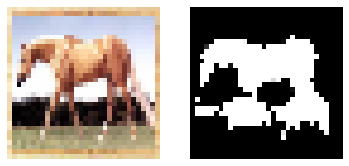

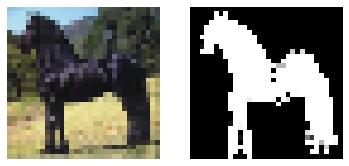

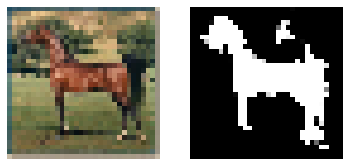

In [40]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

# **Final Output**

In [39]:
iou(ytest, ypred)

0.7203914921217943

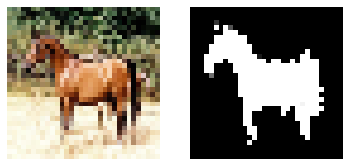

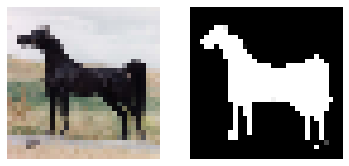

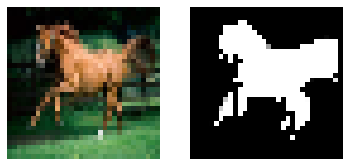

In [23]:
draw(xtest[2], ypred[2])
draw(xtest[12], ypred[12])
draw(xtest[3], ypred[3])

In [24]:
#helper function to drawing horse and its mask
def draw_masks(image, mask):
    fig, (ax1,ax2) = plt.subplots(1,2) 
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(np.reshape(image, (image_size,image_size)), cmap=plt.cm.gray)
    ax2.imshow(np.reshape(mask, (image_size,image_size)), cmap=plt.cm.gray)
    plt.show()

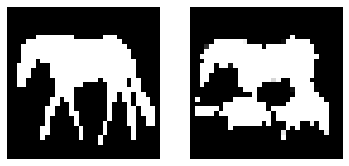

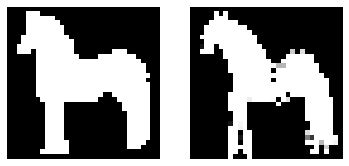

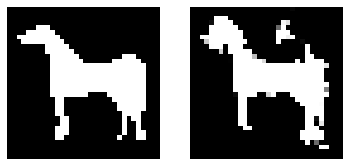

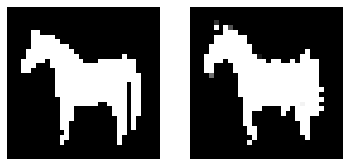

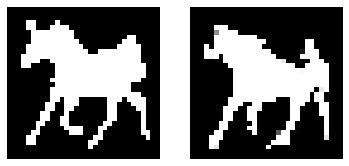

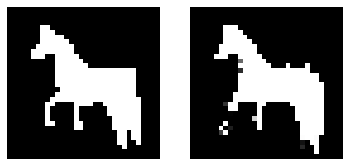

In [41]:
#prediction images
draw_masks(ytest[10], ypred[10])
draw_masks(ytest[25], ypred[25])
draw_masks(ytest[20], ypred[20])
draw_masks(ytest[2],ypred[2])
draw_masks(ytest[7],ypred[7])
draw_masks(ytest[8],ypred[8])

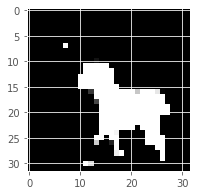

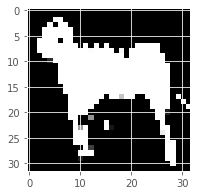

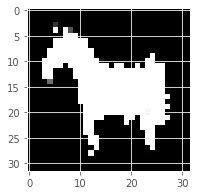

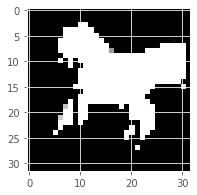

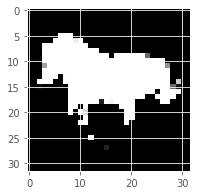

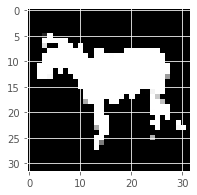

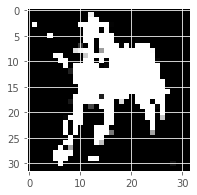

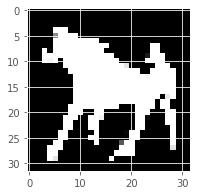

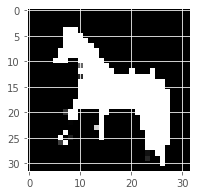

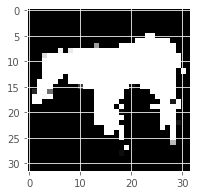

In [43]:
# displaying predictions results for first 50 test images.
i = 0
for X_batch in ypred:
  while i < 10:
    plt.figure(figsize=(3, 3))
    # plt.subplot(10+i)
    plt.imshow(ypred[i].reshape(32,32),cmap='gray')
    i += 1
#   if i >= 9:
  break
  plt.show()

**Model 2**

1. Optimizer - Adam
2. Epochs - 2000
3. Activation Function for last layer - Linear Activation

**Results**

Test Accuracy - 71.2


In [97]:
model = NeuralNet('CNN')
# model = NeuralNet('MLP')
train_iou_Adam = []
val_iou_Adam = []
test_iou_Adam = []
epoch = 1;
best_val_iou = -1
best_test_iou = -1

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_40 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 gaussian_noise_40 (Gaussian  (None, 32, 32, 128)      0         
 Noise)                                                          
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                      

In [87]:
#Adopt similar training loop for other problems
# can do dataaugumentationa and adding noise if required -- kc

max_epoch = 2000

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou_Adam.append(iou(ydata,ydata_pred))
    val_iou_Adam.append(iou(yval,yval_pred))
    test_iou_Adam.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou_Adam[-1]
        best_val_iou = val_iou_Adam[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou_Adam[-1], val_iou_Adam[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 1.18e+05, IOU - Train: 0.0849 Valid: 0.0774 Test: 0.0827
Epoch 2, Loss: 1.15e+05, IOU - Train: 0.0781 Valid: 0.07 Test: 0.0761
Epoch 3, Loss: 1.15e+05, IOU - Train: 0.0715 Valid: 0.0628 Test: 0.0708
Epoch 4, Loss: 1.14e+05, IOU - Train: 0.0892 Valid: 0.0804 Test: 0.0868
Epoch 5, Loss: 1.14e+05, IOU - Train: 0.096 Valid: 0.0844 Test: 0.0931
Epoch 6, Loss: 1.12e+05, IOU - Train: 0.129 Valid: 0.113 Test: 0.119
Epoch 7, Loss: 1.12e+05, IOU - Train: 0.122 Valid: 0.105 Test: 0.115
Epoch 8, Loss: 1.12e+05, IOU - Train: 0.127 Valid: 0.107 Test: 0.114
Epoch 9, Loss: 1.11e+05, IOU - Train: 0.191 Valid: 0.18 Test: 0.188
Epoch 10, Loss: 1.1e+05, IOU - Train: 0.189 Valid: 0.172 Test: 0.177
Epoch 11, Loss: 1.08e+05, IOU - Train: 0.232 Valid: 0.202 Test: 0.213
Epoch 12, Loss: 1.04e+05, IOU - Train: 0.4 Valid: 0.365 Test: 0.387
Epoch 13, Loss: 9.61e+04, IOU - Train: 0.569 Valid: 0.49 Test: 0.531
Epoch 14, Loss: 8.53e+04, IOU - Train: 0.683 Valid: 0.605 Test: 0.648
Epoch 15, Loss: 8.27e+

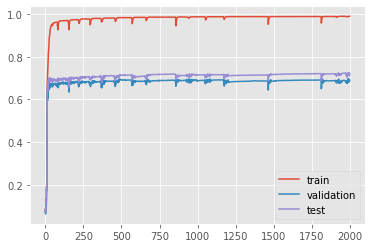

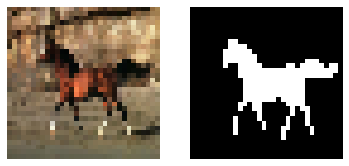

In [92]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou_Adam).plot(ax=ax,label="train")
pd.Series(val_iou_Adam).plot(ax=ax,label="validation")
pd.Series(test_iou_Adam).plot(ax=ax,label="test")
ax.legend()
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [93]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

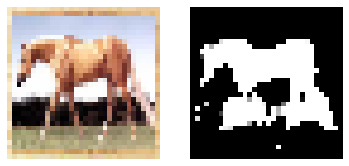

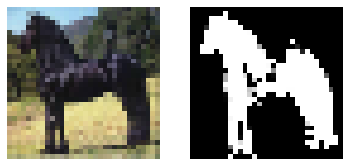

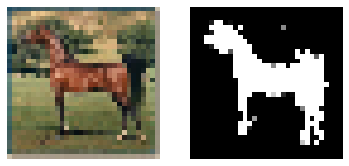

In [94]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [95]:
iou(ytest,ypred)

0.7116765838344397

**Model 3**

1. Optimizer - Adagrad
2. Epochs - 2000
3. Appying tanh activation to last layer

**Results**

Test accuracy - 65.6%

In [101]:
model = NeuralNet('CNN')
# model = NeuralNet('MLP')
train_iou_Adagrad = []
val_iou_Adagrad = []
test_iou_Adagrad = []
epoch = 1;
best_val_iou = -1
best_test_iou = -1

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_50 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 gaussian_noise_50 (Gaussian  (None, 32, 32, 128)      0         
 Noise)                                                          
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                     

In [102]:
#Adopt similar training loop for other problems
# can do dataaugumentationa and adding noise if required -- kc

max_epoch = 2000

while epoch < max_epoch:
    loss = 0.0
    for batch in train_dataset:
        xbatch = batch[:,:image_size*image_size*3]
        ybatch = batch[:,image_size*image_size*3:]
        xbatch = tf.cast(xbatch, tf.float32);
        ybatch = tf.cast(ybatch, tf.float32);
        loss += model.train_step(xbatch, ybatch);
  
    ydata_pred = model.predict(tf.reshape(xdata, (-1, image_size, image_size, 3 )));
    yval_pred = model.predict(tf.reshape(xval, (-1, image_size, image_size, 3 )));
    ytest_pred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));
    
    train_iou_Adagrad.append(iou(ydata,ydata_pred))
    val_iou_Adagrad.append(iou(yval,yval_pred))
    test_iou_Adagrad.append(iou(ytest,ytest_pred))

    if val_iou[-1] > best_val_iou:
        best_test_iou = test_iou_Adagrad[-1]
        best_val_iou = val_iou_Adagrad[-1]
        model.save_weights("best_model");
    
  
    print("Epoch {}, Loss: {:0.3}, IOU - Train: {:0.3} Valid: {:0.3} Test: {:0.3}".format( epoch, loss.numpy(), train_iou_Adagrad[-1], val_iou_Adagrad[-1], best_test_iou))
  

 
    epoch += 1


Epoch 1, Loss: 1.16e+05, IOU - Train: 0.33 Valid: 0.301 Test: 0.333
Epoch 2, Loss: 1.07e+05, IOU - Train: 0.331 Valid: 0.275 Test: 0.327
Epoch 3, Loss: 1.04e+05, IOU - Train: 0.409 Valid: 0.363 Test: 0.407
Epoch 4, Loss: 1.01e+05, IOU - Train: 0.438 Valid: 0.381 Test: 0.432
Epoch 5, Loss: 9.94e+04, IOU - Train: 0.471 Valid: 0.426 Test: 0.47
Epoch 6, Loss: 9.82e+04, IOU - Train: 0.474 Valid: 0.415 Test: 0.465
Epoch 7, Loss: 9.8e+04, IOU - Train: 0.417 Valid: 0.341 Test: 0.406
Epoch 8, Loss: 9.67e+04, IOU - Train: 0.499 Valid: 0.457 Test: 0.494
Epoch 9, Loss: 9.64e+04, IOU - Train: 0.49 Valid: 0.426 Test: 0.473
Epoch 10, Loss: 9.57e+04, IOU - Train: 0.512 Valid: 0.467 Test: 0.502
Epoch 11, Loss: 9.55e+04, IOU - Train: 0.492 Valid: 0.423 Test: 0.468
Epoch 12, Loss: 9.48e+04, IOU - Train: 0.522 Valid: 0.482 Test: 0.512
Epoch 13, Loss: 9.48e+04, IOU - Train: 0.496 Valid: 0.422 Test: 0.471
Epoch 14, Loss: 9.42e+04, IOU - Train: 0.488 Valid: 0.412 Test: 0.461
Epoch 15, Loss: 9.4e+04, IOU - Tr

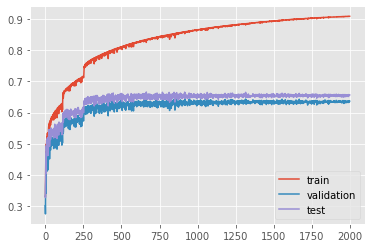

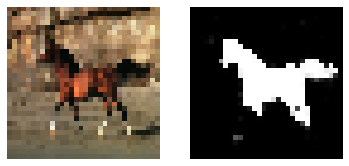

In [103]:
fig, ax = plt.subplots(1,1)
pd.Series(train_iou_Adagrad).plot(ax=ax,label="train")
pd.Series(val_iou_Adagrad).plot(ax=ax,label="validation")
pd.Series(test_iou_Adagrad).plot(ax=ax,label="test")
ax.legend()
fig.canvas.draw()

draw(xdata[0], ydata_pred[0])

In [106]:
model.load_weights("best_model")
ypred = model.predict(tf.reshape(xtest, (-1, image_size, image_size, 3 )));

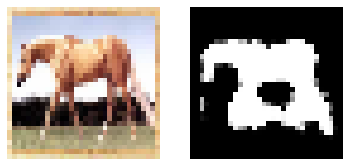

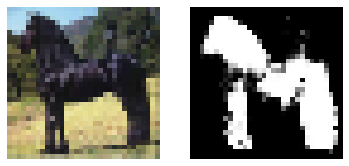

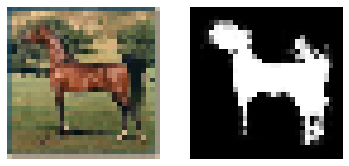

In [108]:
draw(xtest[10], ypred[10])
draw(xtest[25], ypred[25])
draw(xtest[20], ypred[20])

In [107]:
iou(ytest,ypred)

0.6563916146425236

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


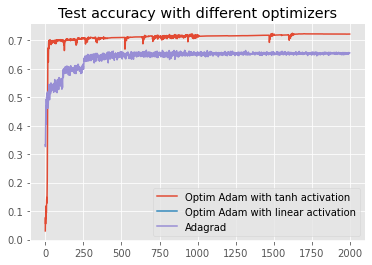

In [112]:
fig, ax = plt.subplots(1,1)
pd.Series(test_iou).plot(ax=ax,label="Optim Adam with tanh activation",title ="Test accuracy with different optimizers" )
pd.Series(test_iou_Adam).plot(ax=ax,label="Optim Adam with linear activation")
pd.Series(test_iou_Adagrad).plot(ax=ax,label="Adagrad")
ax.legend()
# ax.title("Test accuracy with different optimizers")
fig.canvas.draw()


**Data Augmentation**

In [ ]:
# X_train = xdata.reshape(xdata.shape[0],image_size, image_size,3)
# Y_train = ydata.reshape(ydata.shape[0],1,image_size, image_size)
# print(X_train.shape)
# print(Y_train.shape)
# data_augmentation = tf.keras.Sequential([
#   # tf.keras.layers.RandomFlip("horizontal"),
#   tf.keras.layers.RandomTranslation(height_factor =0, width_factor= (-0.02, 0.05),fill_mode='wrap',interpolation='nearest')
#   # tf.keras.layers.Rescaling(1./255)
#   # tf.keras.layers.RandomRotation(0.1),
#   # tf.keras.layers.GaussianNoise(0.2)
# ])

# augmented_image = data_augmentation(X_train)
# augmented_mask = data_augmentation(Y_train)

# augmented_image = np.reshape(np.array(augmented_image), (-1,image_size*image_size*3))
# augmented_mask = np.reshape(np.array(augmented_mask), (-1, image_size * image_size))

# augmented_image = np.array(augmented_image)
# test1 = tf.convert_to_tensor(xdata)
# test2 = tf.convert_to_tensor(augmented_image)
# xdata= tf.concat([test1,test2],0)
# xdata = np.array(xdata)
# print(type(xdata))
# print(xdata.shape)

# augmented_image = np.array(augmented_mask)
# test1 = tf.convert_to_tensor(ydata)
# test2 = tf.convert_to_tensor(augmented_mask)
# ydata= tf.concat([test1,test2],0)
# ydata = np.array(ydata)
# print(type(ydata))
# print(ydata.shape)

In [ ]:
# hrg = 1
# wrg = 1
# print(xdata.shape)
# print(type(ydata))
# h, w = xdata.shape[0], xdata.shape[1]
# tx = np.random.uniform(-hrg, hrg) * h
# ty = np.random.uniform(-wrg, wrg) * w
# test1 = tf.keras.preprocessing.image.random_shift(
#     xdata, wrg, hrg, row_axis=0, col_axis=1, channel_axis=0,
#     fill_mode='nearest', cval=0.0, interpolation_order=1
# )

# test2 = tf.keras.preprocessing.image.random_shift(
#     ydata, wrg, hrg, row_axis=0, col_axis=1, channel_axis=0,
#     fill_mode='nearest', cval=0.0, interpolation_order=1
# )

# xdata = tf.concat([xdata,test1],0)
# ydata = tf.concat([ydata,test2],0)
# xdata = np.array(xdata)
# ydata = np.array(ydata)